In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from TVL2 import *
from TVL2_sampling import *

# Sampling $e^{-H}$

In the following, we wish to draw samples from the distribution 
$$ \pi_{H}(x) \propto e^{-H(x)}.$$
For instance, if we want to know what images with a TV prior look like, we can choose $H(x) = \lambda \mathrm{TV}(x)$. 


In order to draw from $ \pi_{H}$, we will use a Metropolis algorithm.
 We will draw $n_r\times n_c$ images and we call $\Gamma$ the discrete grid $\{1,\dots,n_r\}\times  \{1,\dots,n_c\}$.


### Metropolis algorithm for the simulation of $X\sim \pi_{H}$
1. *Initialization : draw a $n_r\times n_c$ random image $x_0$ (realization of a i.i.d. white noise for instance)*
2. *for k from 1 to N (with N large) :*
    + *draw, independently, a pixel $(i,j)$ with a uniform law on the grid  $\Gamma$, a variable $z\sim \mathcal{U}([0,1])$, and a variable $t \sim \mathcal{U}([-\alpha,\alpha])$* ($\alpha$ is a parameter of the algorithm)
    + *call $x_{temp}$ the image obtained by replacing $x_k(i,j)$ by $x_k(i,j) + t$ and not touching other pixels*
    + *if $z < e^{-(H(x_{temp}) - H(x_k) ) }$, define $x_{k+1} = x_{temp}$ and define $x_{k+1}=x_k$ otherwise.*
3. *Return $x_N$.*-  

### Sampling $e^{- \beta \mathrm{TV}}$

- Implement the previous algorithm to draw samples from the distribution $e^{-\beta \mathrm{TV}}$.
- Be careful when you design the function which computes the difference  $TV(x_{temp}) - TV(x_k)$, you can compute the difference only locally.
- Try to parallelize the function on independent pixels to speed up the computations: pixels at distance larger than 2 can be modified simultaneously, but be careful to compute a test  $z < e^{-(H(x_{temp}) - H(x_k) ) }$ for each of these pixels in order to decide if you keep the modification or not at the pixel.
- Start with a small value of $\beta$ (10 for instance) and draw several samples of the distributions, then increase the value of $\beta$. What do you observe ?  
- Observe also the variation of $TV(u)$ along iterations, for different values of $\beta$.

In [3]:
noise = np.random.rand(50,50)

In [4]:
def TV1(u):
    return  np.sum(np.sum(np.abs(np.roll(u,1,axis=0)- u)+np.abs(np.roll(u,1,axis=1) - u)))

In [5]:
Npas = int(1e4)
alpha = 0.5
beta = [10,100,1000]
t0 = time.time()
out = []

for t in range(len(beta)):
    x = np.copy(noise)  # initialization
    temp = metropolis_TV1(x,alpha,Npas,beta[t])
    out = out + [temp]
        
t1 = time.time()
print(t1-t0)

4.897767782211304


Text(0.5, 1.0, 'beta = 1000')

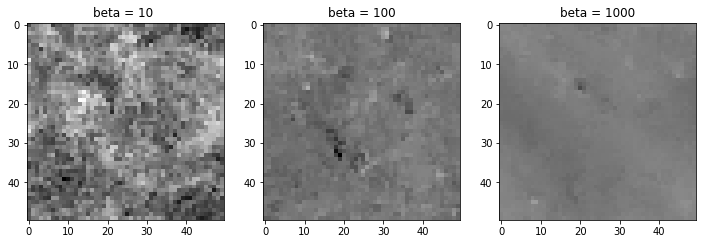

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].imshow(out[0],cmap='gray')
axes[0].set_title('beta = 10 ')
axes[1].imshow(out[1],cmap='gray',vmin =0,vmax = 1 )
axes[1].set_title('beta = 100')
axes[2].imshow(out[2],cmap='gray',vmin =0,vmax = 1 )
axes[2].set_title('beta = 1000')

In [7]:
# To write the result on your disk
#import matplotlib
#matplotlib.image.imsave('sample_TV_beta1000.png', out[2], cmap='gray')

### Sampling $e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$

Now, we wish to sample from the distribution 
$$\pi(u) \propto e^{-\left(\lambda \mathrm{TV(u)+\|u-u_0\|^2/{\sigma^2}}\right)}$$

We can use exactly the same approach as before.
- Implement the previous algorithm to draw samples from the distribution $\pi$. Again write everything locally and parallelize on independent pixels for efficiency.
- Implement your algorithm so you can compute the average value of all samples after a burn-in phase. If $x_t$ is the sample at iteration $t$, you can dot it iteratively by initializing the mean to 0 and updating at iteration t  :
$$x_{mean} = t/(t+1)*x_{mean} + 1/(t+1)*x_{t}$$
- using the same trick, compute the standard deviation of your samples
- as a sanity check, you can observe the number of pixels where the perturbation is accepted at each iteration. This number should be a non trivial proportion of the modified pixels.
- try different initializations for the Markov chain. Does your average posterior depend on your initialization ? 
- compare the average posterior $x_{mean}$ with the MAP obtained with the Chambolle-Pock algorithm.

In [7]:
# ub is the noisy image

def TVL2(x,ub,sigma,lambd):
    return  np.sum(np.sum(0.5*(x-ub)**2))/sigma**2 +  lambd*TV1(x)  

In [8]:
lambd = 40     # TV regularization parameter 
sigma = 0.05  # noise standard deviation

In [9]:
# image creation
n = 50    # start with small images for your experimentations
i = 150
u = plt.imread('./images/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sigma*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sigma**2*lambd,100)

7.519907236099243


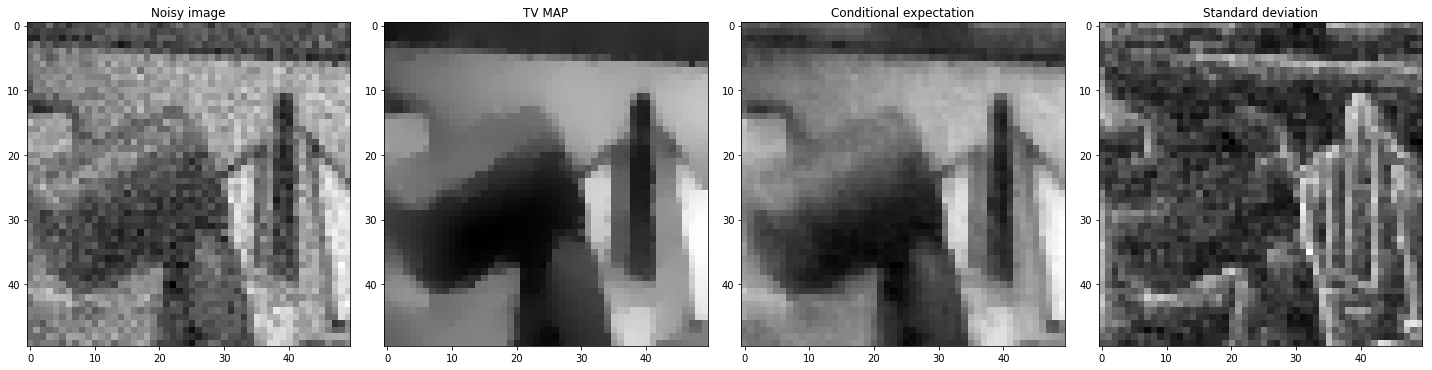

In [11]:
# parameters for the MCMC
Npas = int(4e4)
alpha = 0.5   

t0   = time.time()
# Metropolis algorithm
x     = np.copy(noise) # initialization
x,xmean,stdx = metropolis_TVL2(x,alpha,Npas,ub,sigma,lambd)

t1 = time.time()
print(t1-t0)
    
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
axes[0].imshow(ub,cmap='gray')
axes[0].set_title('Noisy image')
axes[1].imshow(u_tvmap,cmap='gray')
axes[1].set_title('TV MAP')
axes[2].imshow(xmean,cmap='gray')
axes[2].set_title('Conditional expectation')
axes[3].imshow(stdx,cmap='gray')
axes[3].set_title('Standard deviation')
fig.tight_layout()